In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import scipy.stats as sts

filepath_processed = 'C:/Users/Dirk/Google Drive/Dirk/TU/Afstuderen/Afstuderen/Thesis/3. Formalisation/Processed CBS data/'
filepath_raw = 'C:/Users/Dirk/Google Drive/Dirk/TU/Afstuderen/Afstuderen/Thesis/3. Formalisation/Raw CBS data/'
filepath_other = 'C:/Users/Dirk/Google Drive/Dirk/TU/Afstuderen/Afstuderen/Thesis/3. Formalisation/Raw data other/'

In [2]:
#timeit.timeit(pd.read_csv(filepath_processed + 'Total_dataset.csv'))
start = datetime.now()
data =  pd.read_csv(filepath_processed + 'Total_dataset.csv', index_col = 0, 
                    dtype = {'gemeente': str ,'postcode': str ,'huisnummer' : int ,
                             'huisletter': str ,'huisnummertoevoeging': str , 
                             'oppervlakteverblijfsobject' : float ,'pandbouwjaar' : int ,
                             'openbareruimte' : str ,'pandstatus' : str , 'Woningkenmerken': str ,
                             'Energielabel' : str,'leeftijd' : int ,'Age group': str, 
                             'GebruiksOppervlakteklasse' : str,'Bouwjaarklasse' : str,
                             'gasverbruik m3/m2' : float ,'geschat gasverbruik jaarlijks' : float, 
                             'Gemiddelde grootte huishouden' : float , 
                             'elektriciteits verbruik pp' : float , 
                             'geschat elektriciteitsverbruik jaarlijks' : float})

print ('Loading huge dataset took: ' + str((datetime.now()-start).total_seconds()) + ' seconds')

buurten = pd.read_csv(filepath_raw + 'postcode_huisnummer_buurten.csv',delimiter = ';')
wijk = pd.read_csv(filepath_raw + 'wijk2019.csv', delimiter = ';')
buurt = pd.read_csv(filepath_raw + 'buurt2019.csv', delimiter = ';')


C:\Users\Dirk\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (12) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\Dirk\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Loading huge dataset took: 26.71181 seconds


In [3]:
wijk_dict = wijk.astype(str).set_index('Wijkcode2019').to_dict()['Wijknaam_2019K_NAAM']
buurt.Buurtcode_2019 = buurt.Buurtcode_2019.astype(str)
buurt_dict = buurt.set_index('Buurtcode_2019').to_dict()['Buurtnaam_2019']

buurten[['Buurt2019']]= buurten[['Buurt2019']].astype(str)
buurten[['Wijk2019']] = buurten[['Wijk2019']].astype(str)
buurten['buurt_naam'] = buurten['Buurt2019'].map(buurt_dict)
buurten['wijk_naam'] = buurten['Wijk2019'].map(wijk_dict)
buurten = buurten.drop(['Buurt2019','Wijk2019','Gemeente2019'], axis = 1).rename(columns = {'PC6':'postcode','Huisnummer':'huisnummer'})

In [4]:
#Hier aanpassing
data = data.merge(buurten, on = ['postcode','huisnummer'], how = 'inner')

In [5]:
data2 = data.drop(['pandstatus','Bouwjaarklasse', 'Gemiddelde grootte huishouden', 'elektriciteits verbruik pp', 'leeftijd','openbareruimte','postcode', 'huisnummer', 'huisnummertoevoeging','huisletter','pandbouwjaar'],axis =1)

In [6]:
investment_cost = pd.read_csv(filepath_other + 'investment cost CE_Delft.csv')
energy_savings = pd.read_csv(filepath_other + 'Energy savings CE_Delft.csv')
investment_cost.Schil = investment_cost.Schil.str.strip('Huidig ')
energy_savings.Schil = energy_savings.Schil.str.strip('Huidig ')
i_dict = investment_cost.set_index(['Schil', 'Woningtype']).to_dict()
e_dict = energy_savings.set_index('Schil').to_dict()

In [7]:
names = data2.buurt_naam.unique()
names.sort()

In [8]:
# lst = []
# for i in range (10):
#     n = np.random.randint(len(names))
#     lst.append(names[n])

In [9]:
lst = ['Verspreide huizen Zittard',
 'Mariarade-Noord',
 'Zuiderhoofdbuurt',
 'Rivierdijk-Oost',
 'Nunspeet-Oost',
 'Verspreide huizen Burgwerd',
 'De Kiel',
 'Wognum Bloesemgaerde',
 'Tiel-West',
 'Oterleek']

In [10]:
data3 = data2.set_index('buurt_naam').loc[lst].reset_index()

In [11]:
stapel_dict = {'Appartement':'Gestapeld','2-onder-1-kapwoning':'Grondgebonden','Hoekwoning':'Grondgebonden','Tussenwoning':'Grondgebonden','Vrijstaande woning':'Grondgebonden','O':'Grondgebonden','N':'Grondgebonden','C0':'Grondgebonden'}
data3['Type'] = data3['Woningkenmerken'].map(stapel_dict)
gamma_vars = []
for i in energy_savings.Schil[1:7]:
    for j in ['Grondgebonden','Gestapeld']:

        data3['Yearly savings ' + i + ' (m3)'] = data3['geschat gasverbruik jaarlijks'] * data3['Energielabel'].map(e_dict[i])
        data3['Total cost '+ i ] = data3['oppervlakteverblijfsobject'] * pd.Series(list(zip(data3['Energielabel'],data3['Type']))).map(i_dict[i])
        data3['Savings / cost ' + i] = data3['Yearly savings ' + i + ' (m3)'] / data3['Total cost '+ i]
        gamma_vars.extend(['Total cost '+ i,'Savings / cost ' + i])

In [12]:
#For calculating gamma distribution
def alpha(x):
    if x.var() > 0:
        return x.mean()**2 / x.var()
    else:
        return 1
def theta(x):
    if x.var() > 0:
        return x.var() / x.mean()
    else:
        return 1
    
agg_dict = {}
for i in gamma_vars :
    agg_dict[i] = ['mean', alpha, theta]

#data3.groupby(by = ['gemeente','buurt_naam']).agg(['min','mean','max','std', alpha, theta])
data4 = data3.drop(['oppervlakteverblijfsobject','Energielabel','geschat elektriciteitsverbruik jaarlijks','geschat gasverbruik jaarlijks', 'gasverbruik m3/m2'],axis =1)

gamma_dist = data4.groupby(by = ['gemeente','buurt_naam']).agg(agg_dict)#{gamma_vars : ['mean', alpha, theta]})

In [13]:
a = gamma_dist['Total cost A']

In [14]:
a.loc[('Veldhoven', 'Verspreide huizen Zittard')]

mean     24301.462687
alpha        0.290703
theta    83595.576929
Name: (Veldhoven, Verspreide huizen Zittard), dtype: float64

In [15]:
data3['invAcat'] = pd.cut(data3['Total cost A'], bins=[0, 2500, 5000, 7500, 10000, 12500, 15000, 17500, 20000, 22500, 25000, 27500, 30000, 35000], labels=[0, 2500, 5000, 7500, 10000, 12500, 15000, 17500, 20000, 22500, 25000, 27500, 30000])

In [16]:
chart_data=data3.groupby(by = ['buurt_naam','invAcat']).count()['gemeente'].fillna(0)

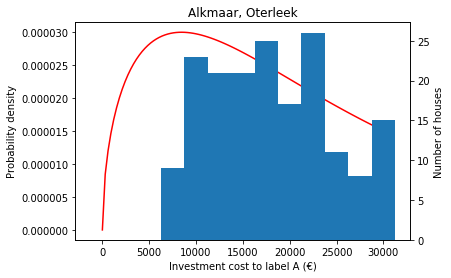

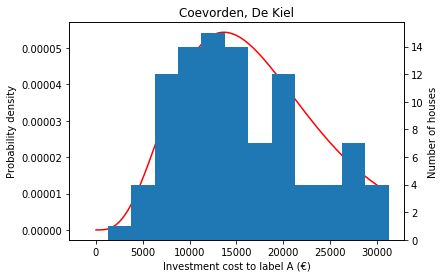

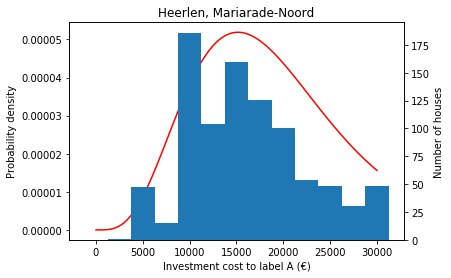

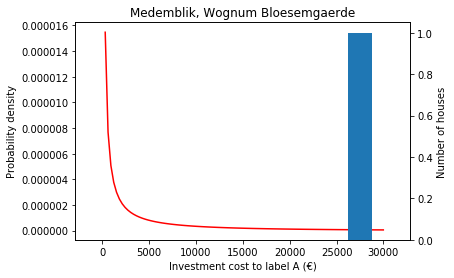

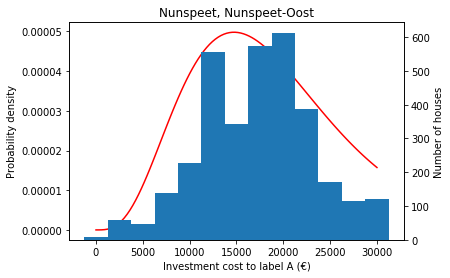

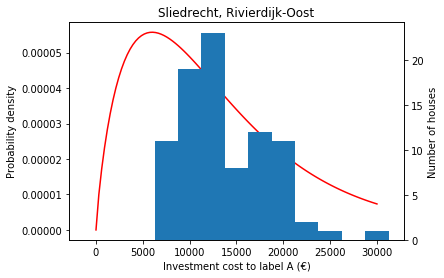

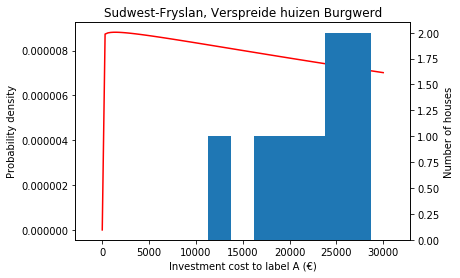

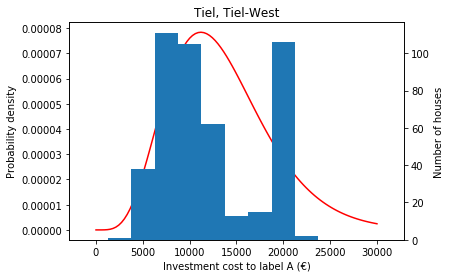

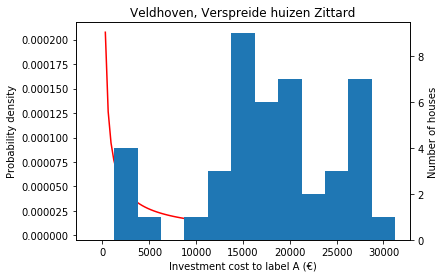

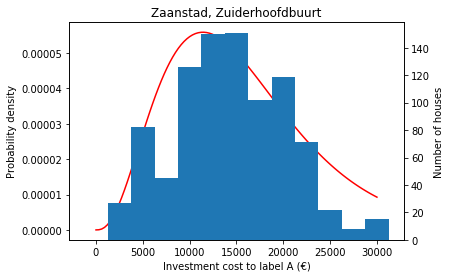

In [17]:
for i in a.index:
    n_data = a.loc[i]

    x = np.linspace (0, 30000, 100) 
    y = sts.gamma.pdf(x, a=n_data['alpha'], scale=n_data['theta'])

    fig, ax1 = plt.subplots()

    ax1.plot(x,y, color = 'red')
    ax2 = ax1.twinx()
    ax2.set_ylabel('Number of houses')
    ax2 = plt.bar(chart_data.loc[i[1]].index,width = 2500, height = chart_data.loc[i[1]], align = 'center')
    ax1.set_title(i[0]+', ' + i[1])    #k+=1
    ax1.set_xlabel('Investment cost to label A (€)')
    ax1.set_ylabel('Probability density')
    
        
    plt.savefig('Gamma_fig_'+i[0]+'_' + i[1])